In [1]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64
from quantecon.optimize.root_finding import brentq

%matplotlib inline

In [2]:
ifp_data = [
    ('γ', float64),              # Utility parameter 
    ('β', float64),              # Discount factor
    ('P', float64[:, :]),        # Transition probs for z_t
    ('σ_vec', float64[:]),       # Shock scale parameters for R_t
    ('s', float64),              # Shock scale parameter for Y_t
    ('a_grid', float64[:]),      # Grid over asset values (array)
    ('η_draws', float64[:]),     # Draws of innovation η for MC (array)
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC (array)
]

In [3]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation 
    problem. 
    """
    def __init__(self,
                 γ=2.5,                        
                 β=0.96,
                 P=np.array([(0.8, 0.2), 
                             (0.7, 0.3)]),
                 σ_vec=np.array((0.0, 0.5)),
                 s=0.5,
                 shock_draw_size=400,
                 grid_max=10,
                 grid_size=20):
        
        np.random.seed(1234)  # arbitrary seed

        self.γ, self.β = γ, β
        self.P, self.σ_vec, self.s = P, σ_vec, s
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.a_grid = np.linspace(0, grid_max, grid_size)
        
    # Marginal utility    
    def u_prime(self, c):
        return c**(-self.γ)
    
    def R(self, z, ζ):
        return np.exp(self.σ_vec[z] * ζ)
    
    def Y(self, η):
        return np.exp(self.s * η)

In [4]:
@njit
def euler_diff(t, c_vec, a, z, ifp):
    """
    The difference of the left-hand side and the right-hand side
    of the Euler Equation, given a policy represented by c_vec.
    """
    # Simplify names
    u_prime, R, Y, P = ifp.u_prime, ifp.R, ifp.Y, ifp.P
    a_grid, η_draws, ζ_draws = ifp.a_grid, ifp.η_draws, ifp.η_draws
    β = ifp.β
    
    # Create consumption function a -> c(a, z) by linear interpolation
    c = lambda a, z: interp(a_grid, c_vec[:, z], a)
    
    # Compute expectation on right hand side by Monte Carlo
    Ez = 0.0
    for z_hat in (0, 1):
        for η in ifp.η_draws:
            for ζ in ifp.ζ_draws:
                
                R_hat = R(z_hat, ζ)
                Y_hat = Y(η)
                
                Ez += R_hat * \
                      u_prime(c(R_hat * (a - t) + Y_hat, z_hat)) * \
                      P[z, z_hat]
                
    Ez = Ez / (len(η_draws) * len(ζ_draws))

    return u_prime(t) - max(β * Ez, u_prime(a))

In [5]:
ifp = IFP()
# Initial guess of c_vec = consume all assets
n = len(ifp.a_grid)
c_init = np.ones((n, 2))
for z in 0, 1:
    c_init[:, z] = ifp.a_grid

In [ ]:
a = 1.0
t = 0.99 * a
z = 1

In [16]:
%%time 

euler_diff(t, c_init, a, z, ifp)

CPU times: user 44.9 ms, sys: 0 ns, total: 44.9 ms
Wall time: 44.7 ms


-0.9003939231781253

In [17]:
%%time

brentq(euler_diff, 1e-10, a, args=(c_init, a, z, ifp)).root

CPU times: user 419 ms, sys: 0 ns, total: 419 ms
Wall time: 418 ms


0.90603160583869

In [13]:
def K(c_vec, ifp):
    """
    The operator K.

    Iteration with this operator corresponds to time iteration on the
    Euler equation.  Computes and returns the updated consumption 
    policy values on the grid pairs (a, z).

    """
    c_new = np.empty_like(c_vec)
    for i in range(len(ifp.a_grid)):
        a = ifp.a_grid[i]
        for z in 0, 1:
            c_star = brentq(euler_diff, 1e-10, a, 
                            args=(c_vec, a, z, ifp),
                            maxiter=12,
                            disp=False)
            c_new[i, z] = c_star.root

    return c_new


In [15]:
%%time

K(c_init, ifp)

CPU times: user 19.7 s, sys: 9.96 ms, total: 19.7 s
Wall time: 19.7 s


array([[0.        , 0.        ],
       [0.52631579, 0.52631579],
       [0.93728521, 0.93736246],
       [1.23606604, 1.23718619],
       [1.52229523, 1.52381684],
       [1.80220421, 1.80377159],
       [2.07826035, 2.07963443],
       [2.3517228 , 2.35272717],
       [2.62332499, 2.62382237],
       [2.89353195, 2.89341161],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [5.02768988, 5.01944975],
       [0.        , 0.        ],
       [5.55530451, 5.54355308]])

In [10]:
def solve_model(ifp,
                tol=1e-3,
                max_iter=100,
                verbose=True,
                print_skip=4):

    """
    Solves for the optimal policy using time iteration

    * ifp is an instance of ConsumerProblem
    """


    # Initial guess of c_vec = consume all assets
    n = len(ifp.a_grid)
    c_init = np.ones((n, 2))
    for z in 0, 1:
        c_init[:, z] = ifp.a_grid

    i = 0
    error = tol + 1
    c = c_init

    while i < max_iter and error > tol:
        c_new = K(c, ifp)
        error = np.max(np.abs(c - c_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        c = c_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return c_new

In [11]:
ifp = IFP()
c_star = solve_model(ifp)

Error at iteration 4 is 0.43559352436746224.
Error at iteration 8 is 0.11487958941087406.
Error at iteration 12 is 0.05021667036419597.
Error at iteration 16 is 0.02719619562594633.
Error at iteration 20 is 0.016585744844914485.
Error at iteration 24 is 0.010888713475715184.
Error at iteration 28 is 0.00750598280201209.
Error at iteration 32 is 0.005355319915721246.
Error at iteration 36 is 0.003919287274138483.
Error at iteration 40 is 0.002922454497051641.
Error at iteration 44 is 0.0022101408940478073.
Error at iteration 48 is 0.0016897538165097092.
Error at iteration 52 is 0.0013028672889148218.
Error at iteration 56 is 0.0010110675120353907.
Error at iteration 60 is 0.0007886269182983963.
Error at iteration 64 is 0.0006175870722961996.
Error at iteration 68 is 0.00048520068267987604.
Error at iteration 72 is 0.00038212525710035194.
Error at iteration 76 is 0.00030153083595307884.
Error at iteration 80 is 0.00023830798264135034.
Error at iteration 84 is 0.0001885713168323644.
Error

Plot consumption policy

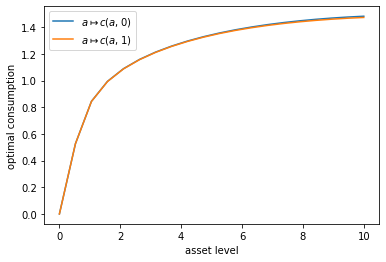

In [12]:
fig, ax = plt.subplots()

for z in 0, 1:
    ax.plot(ifp.a_grid, c_star[:, z], label=f'$a \mapsto c(a, {z})$')
    
ax.set(xlabel='asset level', ylabel='optimal consumption')
ax.legend()
plt.show()

Plot expected asset change

In [ ]:
fig, ax = plt.subplots()

a = ifp.a_grid

for z in 0, 1:
    
    ax.plot(a, c_star[:, z], label=f'$a \mapsto c(a, {z})$')
    
ax.set(xlabel='asset level', ylabel='optimal consumption')
ax.legend()
plt.show()

## Solutions

### Exercise 1

In [ ]:
r_vals = np.linspace(0, 0.04, 4)

fig, ax = plt.subplots(figsize=(10, 8))
for r_val in r_vals:
    cp = ConsumerProblem(r=r_val)
    σ_star = solve_model(cp, verbose=False)
    ax.plot(cp.asset_grid, σ_star[:, 0], label=f'$r = {r_val:.3f}$')

ax.set(xlabel='asset level', ylabel='consumption (low income)')
ax.legend()
plt.show()

### Exercise 2

In [ ]:
def compute_asset_series(cp, T=500000, verbose=False):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

    cp is an instance of ConsumerProblem
    """
    Π, z_vals, R = cp.Π, cp.z_vals, cp.R  # Simplify names
    mc = MarkovChain(Π)
    σ_star = solve_model(cp, verbose=False)
    cf = lambda a, i_z: interp(cp.asset_grid, σ_star[:, i_z], a)
    a = np.zeros(T+1)
    z_seq = mc.simulate(T)
    for t in range(T):
        i_z = z_seq[t]
        a[t+1] = R * a[t] + z_vals[i_z] - cf(a[t], i_z)
    return a

cp = ConsumerProblem(r=0.03, grid_max=4)
a = compute_asset_series(cp)

fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(a, bins=20, alpha=0.5, density=True)
ax.set(xlabel='assets', xlim=(-0.05, 0.75))
plt.show()

### Exercise 3

In [ ]:
M = 25
r_vals = np.linspace(0, 0.04, M)
fig, ax = plt.subplots(figsize=(10, 8))

for b in (1, 3):
    asset_mean = []
    for r_val in r_vals:
        cp = ConsumerProblem(r=r_val, b=b)
        mean = np.mean(compute_asset_series(cp, T=250000))
        asset_mean.append(mean)
    ax.plot(asset_mean, r_vals, label=f'$b = {b:d}$')
    print(f"Finished iteration b = {b:d}")

ax.set(xlabel='capital', ylabel='interest rate')
ax.grid()
ax.legend()
plt.show()